Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import time
import glob

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category = ConvergenceWarning)

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

Importing predictMissing function from p4 notebook

In [2]:
import nbimporter

from p4_AdvancedStats import predictMissing

Importing team dataframe models into a dictionary

In [3]:
directory = '/users/blaizelahman/Desktop/CFB Model/Updated Data'
pattern = os.path.join(directory, '*updated_model*.csv')

teamFiles = glob.glob(pattern)

teamDict = {}

for file in teamFiles:

    teamDF = pd.read_csv(file)

    if teamDF.shape[0] >= 56:

        # throwing out first 20 rows due to missing rolling_sum data
        teamDF = teamDF.drop(teamDF.index[:20])
        teamDF = teamDF.reset_index(drop = True)
    
        key = teamDF['School'][0]
        teamDict[key] = teamDF
    
        print(f'Added: {key}')

Added: Louisiana Tech
Added: Southern Mississippi
Added: Arizona State
Added: Auburn
Added: Texas Tech
Added: Minnesota
Added: NC State
Added: Georgia
Added: USC
Added: South Florida
Added: Wisconsin
Added: Miami
Added: Mississippi State
Added: Houston
Added: San José State
Added: Oklahoma State
Added: UCLA
Added: Rice
Added: Texas State
Added: Iowa
Added: Western Michigan
Added: Charlotte
Added: Florida International
Added: Ole Miss
Added: UTEP
Added: Boston College
Added: Troy
Added: Wake Forest
Added: Baylor
Added: Bowling Green
Added: TCU
Added: Virginia
Added: Utah State
Added: Appalachian State
Added: Michigan
Added: New Mexico State
Added: SMU
Added: South Carolina
Added: Georgia Southern
Added: Vanderbilt
Added: California
Added: Ohio State
Added: Louisiana Monroe
Added: Louisiana
Added: Eastern Michigan
Added: UMass
Added: Alabama
Added: Miami (OH)
Added: Iowa State
Added: Arizona
Added: UAB
Added: Akron
Added: Cincinnati
Added: Virginia Tech
Added: Tulane
Added: Texas
Added: 

Creating a function that builds a model and returns its predictions for a corresponding team in a given year

In [4]:
def buildModel(team, features, year, randomState):

    # calling function to predict the missing values
    predictMissing(team, fixCols, randomState)
    
    # setting up training and test sets
    # only using data from before the given year because we'll be predicting data from given year
    modelTeam = team[team['Year'] < year]

    # to be used for finding the best alpha level
    X = modelTeam[features]
    y = modelTeam[['scoreDiff']].values.ravel()

    # to be used for predicting predicting the given year's score differentials
    xTrain = modelTeam[features]
    xTest = team[features][team['Year'] == year]
    yTrain = modelTeam[['scoreDiff']].values.ravel()

    # checks if the season we're testing has less than 8 games (meaning they had 
    # half their season canceled for some reason) and returns null if so
    if len(yTrain) < 8:
        return None

    # setting up pipeline
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
        ('scaler', StandardScaler()),
        ('regressor', Lasso())
    ])

    # setting up and performing grid search to find best alpha level
    paramGrid = {
        'regressor__alpha': np.logspace(-4, 4, 50)
    }
    
    gridSearch = GridSearchCV(pipe, paramGrid, cv = 5, scoring = 'neg_mean_absolute_error')

    gridSearch.fit(X, y)
    
    bestAlpha = gridSearch.best_params_['regressor__alpha']

    # setting up new pipeline with the ideal alpha level and a bagging regressor
    betterPipe = Pipeline([
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
        ('scaler', StandardScaler()),
        ('regressor', BaggingRegressor(estimator = Lasso(alpha = bestAlpha, max_iter = 10000), n_estimators = 50, n_jobs = -1))
    ])

    betterPipe.fit(xTrain, yTrain)

    testPreds = betterPipe.predict(xTest)
    
    # rounding each predicted score to the nearest 0.5 increment, which is how Vegas sets 
    # their spreads (predicted score differntials)
    return np.round(testPreds * 2) / 2

Creating a function that will make a dictionary of every team and their corresponding model's predicted score differentials

In [5]:
features = [col for col in teamDict['Florida State'].columns if any(word in col for word in ['rolling_sum','talent','SP'])]
fixCols = [col for col in features if any(word in col for word in ['tackle', 'sacks', 'Deflected', 'defensive', 'qbHurries', 'fumbles', 'kickReturn', 'penalty', 'Fumble', 'talent', 'SP'])]

# function will take a 2-3 min
def grabPreds(teamDict, features, year, randomState):
    
    teamPreds = {}

    # grabbing teams from teamDict and grabbing their model's predictions
    for team, teamDF in teamDict.items():
        
        preds = buildModel(teamDF, features, year, randomState)
        teamPreds[team] = preds

    # return dicitionary of all team predictions
    return teamPreds


Checking that this worked as intended

In [6]:
teamPreds = grabPreds(teamDict, features, 2023, 50)
teamPreds['Missouri']

array([ 40. ,  19. ,  -0.5,   8. ,  19.5,  -6.5,   3. ,   9. , -14. ,
        -4. ,   4.5,  10. ])

Examining how well our model does when predicting games based on the Vegas spread

In [7]:
# dictionary to hold the percent of times the model correctly predicted based on the spread for each individual team
modelResultsByTeam = {}

# list to hold all the comparisons so that we can aggregate all the predictions and get the proportion of right ones
modelResults = []

for team, preds in teamPreds.items():
    
    # grabbing Vegas spreads and the actual results of games
    vegas = teamDict[team][['Spread']][teamDict[team]['Year'] == 2023].values.flatten()
    scoreDiffs = teamDict[team][['scoreDiff']][teamDict[team]['Year'] == 2023].values.flatten()

    # creating an array of what side of the spread our model is taking (1 if we predict a higher score differential,
    # -1 if we predict a lower one, 0 if we predict the same)
    bets = np.array([1 if pred > spread else -1 if pred < spread else 0 for pred, spread in zip(preds, vegas)])

    # making a similar array but this time getting the actual outcome of if it was higher or lower than the Vegas spread
    results = np.array([1 if result > spread else -1 if result < spread else 0 for result, spread in zip(scoreDiffs, vegas)])
        
    # grabbing the total amount of pushes
    pushTotal = np.sum((results == 0))

    # removing pushes from bets and results so we can accurately get a true success rate
    notPushes = ~((results == 0))

    # making new versions of bets and results with all indexes where there was a push taken out
    newBets = bets[notPushes]
    newResults = results[notPushes]
        
    # getting proportion of times model correctly predicted based on Vegas spreads
    beatVegas = np.sum(newBets == newResults)
    beatVegasPercent = beatVegas / len(scoreDiffs)

    # getting percent of the time the model pushed
    pushPercent = pushTotal / len(scoreDiffs)

    # assigning each team with how well the model did when predicting their games and their push percentage 
    modelResultsByTeam[team] = [beatVegasPercent, pushPercent]
    print(f'{team}: {beatVegasPercent}, {pushPercent}')

    # getting the indices of model wins, losses, pushes, and toss ups
    wins = ((bets == results) & (bets != 0))
    losses = ((bets != results) & (bets != 0))
    pushes = ((results == 0))
    tossUps = ((bets == 0))
        
    # crating a new array to hold the results of the model, 1 meaning it won, 0 meaning it pushed, -1 meaning it lost,
    # and 2 meaning it was a toss up
    modelPredsResults = np.zeros_like(bets, dtype = int)

    modelPredsResults[wins] = 1
    modelPredsResults[losses] = -1
    modelPredsResults[tossUps] = 2
    modelPredsResults[pushes] = 0
        
    # adding all the new comparisons to the aggregate list
    modelResults.extend(modelPredsResults)



Louisiana Tech: 0.5, 0.0
Southern Mississippi: 0.5, 0.0
Arizona State: 0.75, 0.0
Auburn: 0.4166666666666667, 0.0
Texas Tech: 0.5833333333333334, 0.0
Minnesota: 0.25, 0.08333333333333333
NC State: 0.75, 0.0
Georgia: 0.6153846153846154, 0.07692307692307693
USC: 0.5833333333333334, 0.0
South Florida: 0.8333333333333334, 0.0
Wisconsin: 0.5833333333333334, 0.0
Miami: 0.6666666666666666, 0.0
Mississippi State: 0.5, 0.0
Houston: 0.3333333333333333, 0.0
San José State: 0.4166666666666667, 0.0
Oklahoma State: 0.6153846153846154, 0.0
UCLA: 0.4166666666666667, 0.0
Rice: 0.5833333333333334, 0.0
Texas State: 0.5833333333333334, 0.0
Iowa: 0.5384615384615384, 0.0
Western Michigan: 0.5833333333333334, 0.0
Charlotte: 0.6666666666666666, 0.0
Florida International: 0.8333333333333334, 0.0
Ole Miss: 0.5833333333333334, 0.08333333333333333
UTEP: 0.5, 0.08333333333333333
Boston College: 0.5, 0.0
Troy: 0.38461538461538464, 0.0
Wake Forest: 0.4166666666666667, 0.0
Baylor: 0.6666666666666666, 0.083333333333333

Creating a function that will caclulate the results of our model

In [8]:
def calculateModelResults(modelResults):
    
    modelResults = np.array(modelResults)
    percentCorrect = np.sum(modelResults == 1) / len(modelResults) * 100
    percentLost = np.sum(modelResults == -1) / len(modelResults) *100
    percentPushed = np.sum(modelResults == 0) / len(modelResults) * 100
    percentTossUp = np.sum(modelResults == 2) / len(modelResults) * 100
    
    print(f'Percent of all games our model was correct when predicting based on Vegas spreads: {percentCorrect:.2f}%')
    print(f'Percent of all games our model was wrong: {percentLost:.2f}%')
    print(f'Percent of all games our model pushed: {percentPushed:.2f}%')
    print(f'Percent of all games that were tossups: {percentTossUp:.2f}%')
    print(f'Games: {len(modelResults)}')


In [9]:
calculateModelResults(modelResults)

Percent of all games our model was correct when predicting based on Vegas spreads: 57.22%
Percent of all games our model was wrong: 37.68%
Percent of all games our model pushed: 2.55%
Percent of all games that were tossups: 2.55%
Games: 1566


This is pretty good when it comes to predicting based on Vegas spreads, but right now we're double counting games (predicting them twice from each team's POV). Let's fix that.

In [10]:
modelResults = []

# sorting the dictionary by keys so we can determine if a game has been predicted before by a previous team
sortedPreds = {key: teamPreds[key] for key in sorted(teamPreds)}

for team, preds in sortedPreds.items():

    # grabbing Vegas spreads and the actual results of games
    vegas = teamDict[team][['Spread']][teamDict[team]['Year'] == 2023].values.flatten()
    scoreDiffs = teamDict[team][['scoreDiff']][teamDict[team]['Year'] == 2023].values.flatten()

    # list to hold indices of double counted games that will have to be removed
    removeIndices = []
        
    # removing all games where the model's prediction has already been compared (by the other team) to the result
    for index, game in enumerate(preds):

        # getting the opponent's name by accessing the team's dataframe
        oppTeams = teamDict[team][['School_opp']][teamDict[team]['Year'] == 2023].reset_index(drop = True)
        oppName = oppTeams.iloc[index].values[0]

        # checking if the opponent has already done results of their model, meaning we can remove this game
        if oppName < team and oppName in sortedPreds:

            # adding index to be removed
            removeIndices.append(index)

    # removing double counted games if there are any
    if len(removeIndices) > 0:
        preds = np.delete(preds, removeIndices)
        vegas = np.delete(vegas, removeIndices)
        scoreDiffs = np.delete(scoreDiffs, removeIndices)
        
    # creating an array of what side of the spread our model is taking (1 if we predict a higher score differential,
    # -1 if we predict a lower one, 0 if we predict the same)
    bets = np.array([1 if pred > spread else -1 if pred < spread else 0 for pred, spread in zip(preds, vegas)])

    # making a similar array but this time getting the actual outcome of if it was higher or lower than the Vegas spread
    results = np.array([1 if result > spread else -1 if result < spread else 0 for result, spread in zip(scoreDiffs, vegas)])

    # getting the indices of model wins, losses, pushes, and toss ups
    wins = ((bets == results) & (bets != 0))
    losses = ((bets != results))
    tossUps = ((bets == 0))
    pushes = ((results == 0))
        
    # crating a new array to hold the results of the model, 1 meaning it won, 0 meaning it pushed, -1 meaning it lost,
    # and 2 meaning it was a toss up
    modelPredsResults = np.zeros_like(bets, dtype = int)

    modelPredsResults[wins] = 1
    modelPredsResults[losses] = -1
    modelPredsResults[tossUps] = 2
    modelPredsResults[pushes] = 0
    
    # adding all the new comparisons to the aggregate list
    modelResults.extend(modelPredsResults)


In [11]:
calculateModelResults(modelResults)

Percent of all games our model was correct when predicting based on Vegas spreads: 58.71%
Percent of all games our model was wrong: 35.76%
Percent of all games our model pushed: 2.77%
Percent of all games that were tossups: 2.77%
Games: 867


This is really really good as far as predicting agaisnt Vegas goes.
Let's see if we would turn a good profit by actually betting real money based on our model.

To calculate how much money you would win based on the negative odds of a game (most spreads are -110), the formula is: 100/odds x wager.

In [12]:
# let's test it with a wager of $100
wager = 100
profit = 100/110 * wager
print(f'${profit:.2f}')

$90.91


The amount of money you bet with is called a "bankroll", and it is considered 'safe' to bet with a bankroll that is 50x the size of your intended bet size. Let's make a function to see how much profit our model would make us if we were to bet on every single game our model predicts.

In [13]:
def profitCalculator(betSize, modelResults):

    # setting up bankroll and how much would be won/lost with a win/loss 
    bankroll = betSize * 50
    profit = 100/110 * betSize
    loss = -betSize

    # setting up counter so we can see how many bets we got right, wrong, pushed
    # (a push is when you bet the predicted score differential and that is the 
    # exact score differential of the game, meaning you get your money back), or was a toss up
    # (our prediction was the same as the spread)
    winTotal = 0
    lossTotal = 0
    pushTotal = 0
    tossUpTotal = 0
    
    for result in modelResults:
        if result == 1:
            bankroll += profit
            winTotal += 1
        elif result == -1:
            bankroll += loss
            lossTotal += 1
        elif result == 2:
            tossUpTotal += 1
        else:
            pushTotal += 1

    
    print(f'Won: {winTotal} \nLost: {lossTotal} \nPushed: {pushTotal} \nToss ups: {tossUpTotal} \n\nProfit: ${(bankroll - (betSize * 50)):.2f}')

Seeing how much money different betSizes would make us

In [14]:
for betSize in [1, 10, 50, 100]:
    print(f'Bet size: ${betSize}')
    profitCalculator(betSize, modelResults)
    print()

Bet size: $1
Won: 509 
Lost: 310 
Pushed: 24 
Toss ups: 24 

Profit: $152.73

Bet size: $10
Won: 509 
Lost: 310 
Pushed: 24 
Toss ups: 24 

Profit: $1527.27

Bet size: $50
Won: 509 
Lost: 310 
Pushed: 24 
Toss ups: 24 

Profit: $7636.36

Bet size: $100
Won: 509 
Lost: 310 
Pushed: 24 
Toss ups: 24 

Profit: $15272.73



This is *very* good, let's see if we can replicate this success in other years besides 2023.

In [15]:
teamDict['Florida State'][teamDict['Florida State']['Year'] == 2023]

,Unnamed: 0,Game Id,School,Conference,HomeAway,Points,Week,Year,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,interceptions,kickReturnTDs,kickReturnYards,kickReturns,kickingPoints,netPassingYards,passesDeflected,passesIntercepted,passingTDs,possessionTime,puntReturnTDs,puntReturnYards,puntReturns,qbHurries,rushingAttempts,rushingTDs,rushingYards,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt,totalTDs,School_opp,Conference_opp,HomeAway_opp,Points_opp,Week_opp,Year_opp,completionAttempts_opp,defensiveTDs_opp,firstDowns_opp,fourthDownEff_opp,fumblesLost_opp,fumblesRecovered_opp,interceptionTDs_opp,interceptionYards_opp,interceptions_opp,kickReturnTDs_opp,kickReturnYards_opp,kickReturns_opp,kickingPoints_opp,netPassingYards_opp,passesDeflected_opp,passesIntercepted_opp,passingTDs_opp,possessionTime_opp,puntReturnTDs_opp,puntReturnYards_opp,puntReturns_opp,qbHurries_opp,rushingAttempts_opp,rushingTDs_opp,rushingYards_opp,sacks_opp,tackles_opp,tacklesForLoss_opp,thirdDownEff_opp,totalFumbles_opp,totalPenaltiesYards_opp,totalYards_opp,turnovers_opp,yardsPerPass_opp,yardsPerRushAttempt_opp,totalTDs_opp,scoreDiff,pointTotal,Win,rolling_sum_Points20,rolling_sum_firstDowns20,rolling_sum_fumblesLost20,rolling_sum_fumblesRecovered20,rolling_sum_interceptions20,rolling_sum_kickReturnYards20,rolling_sum_kickingPoints20,rolling_sum_netPassingYards20,rolling_sum_passesDeflected20,rolling_sum_passesIntercepted20,rolling_sum_passingTDs20,rolling_sum_puntReturns20,rolling_sum_qbHurries20,rolling_sum_rushingAttempts20,rolling_sum_rushingTDs20,rolling_sum_rushingYards20,rolling_sum_sacks20,rolling_sum_tacklesForLoss20,rolling_sum_totalFumbles20,rolling_sum_totalPenaltiesYards20,rolling_sum_totalYards20,rolling_sum_turnovers20,rolling_sum_yardsPerPass20,rolling_sum_yardsPerRushAttempt20,rolling_sum_totalTDs20,rolling_sum_Points8,rolling_sum_firstDowns8,rolling_sum_fumblesLost8,rolling_sum_fumblesRecovered8,rolling_sum_interceptions8,rolling_sum_kickReturnYards8,rolling_sum_kickingPoints8,rolling_sum_netPassingYards8,rolling_sum_passesDeflected8,rolling_sum_passesIntercepted8,rolling_sum_passingTDs8,rolling_sum_puntReturns8,rolling_sum_qbHurries8,rolling_sum_rushingAttempts8,rolling_sum_rushingTDs8,rolling_sum_rushingYards8,rolling_sum_sacks8,rolling_sum_tacklesForLoss8,rolling_sum_totalFumbles8,rolling_sum_totalPenaltiesYards8,rolling_sum_totalYards8,rolling_sum_turnovers8,rolling_sum_yardsPerPass8,rolling_sum_yardsPerRushAttempt8,rolling_sum_totalTDs8,rolling_sum_Points20_opp,rolling_sum_firstDowns20_opp,rolling_sum_fumblesLost20_opp,rolling_sum_fumblesRecovered20_opp,rolling_sum_interceptions20_opp,rolling_sum_kickReturnYards20_opp,rolling_sum_kickingPoints20_opp,rolling_sum_netPassingYards20_opp,rolling_sum_passesDeflected20_opp,rolling_sum_passesIntercepted20_opp,rolling_sum_passingTDs20_opp,rolling_sum_puntReturns20_opp,rolling_sum_qbHurries20_opp,rolling_sum_rushingAttempts20_opp,rolling_sum_rushingTDs20_opp,rolling_sum_rushingYards20_opp,rolling_sum_sacks20_opp,rolling_sum_tacklesForLoss20_opp,rolling_sum_totalFumbles20_opp,rolling_sum_totalPenaltiesYards20_opp,rolling_sum_totalYards20_opp,rolling_sum_turnovers20_opp,rolling_sum_yardsPerPass20_opp,rolling_sum_yardsPerRushAttempt20_opp,rolling_sum_totalTDs20_opp,rolling_sum_Points8_opp,rolling_sum_firstDowns8_opp,rolling_sum_fumblesLost8_opp,rolling_sum_fumblesRecovered8_opp,rolling_sum_interceptions8_opp,rolling_sum_kickReturnYards8_opp,rolling_sum_kickingPoints8_opp,rolling_sum_netPassingYards8_opp,rolling_sum_passesDeflected8_opp,rolling_sum_passesIntercepted8_opp,rolling_sum_passingTDs8_opp,rolling_sum_puntReturns8_opp,rolling_sum_qbHurries8_opp,rolling_sum_rushingAttempts8_opp,rolling_sum_rushingTDs8_opp,rolling_sum_rushingYards8_opp,rolling_sum_sacks8_opp,rolling_sum_tacklesForLoss8_opp,rolling_sum_totalFumbles8_opp,rolling_sum_totalP

Creating a function that takes in a year and outputs the model's predictions for that year based on previous data

In [16]:
def modelPredictYear(year, features, randomState):

    fixCols = [col for col in features if any(word in col for word in ['tackle', 'sacks', 'Deflected', 'defensive', 'qbHurries', 'fumbles', 'kickReturn', 'penalty', 'Fumble', 'talent', 'SP'])]

    teamPreds = grabPreds(teamDict, features, year, randomState)

    sortedPreds = {key: teamPreds[key] for key in sorted(teamPreds)}

    # making an array to store aggregate model results data
    modelResults = []

    # making arrays to store aggregate model predictions and Vegas spreads to be compared later
    totalPreds = []
    totalVegas = []
    totalDiffs = []
    
    # sorting the dictionary by keys so we can determine if a game has been predicted before by a previous team
    for team, preds in sortedPreds.items():

        # check if the current team didn't have enough data and skip it if so
        if preds is None:
            continue
    
        # grabbing Vegas spreads and the actual results of games
        vegas = teamDict[team][['Spread']][teamDict[team]['Year'] == year].values.flatten()
        scoreDiffs = teamDict[team][['scoreDiff']][teamDict[team]['Year'] == year].values.flatten()
    
        # list to hold indices of double counted games that will have to be removed
        removeIndices = []
            
        # removing all games where the model's prediction has already been compared (by the other team) to the result
        for index, game in enumerate(preds):
    
            # getting the opponent's name by accessing the team's dataframe
            oppTeams = teamDict[team][['School_opp']][teamDict[team]['Year'] == year].reset_index(drop = True)
            oppName = oppTeams.iloc[index].values[0]
    
            # checking if the opponent has already done results of their model, meaning we can remove this game
            if oppName < team and oppName in sortedPreds:
    
                # adding index to be removed
                removeIndices.append(index)

        # removing double counted games if there are any
        if len(removeIndices) > 0:
            preds = np.delete(preds, removeIndices)
            vegas = np.delete(vegas, removeIndices)
            scoreDiffs = np.delete(scoreDiffs, removeIndices)

        # adding the current predictions and Vegas spreads to their aggregate lists
        totalPreds.extend(preds)
        totalVegas.extend(vegas)
        totalDiffs.extend(scoreDiffs)
            
        # creating an array of what side of the spread our model is taking (1 if we predict a higher score differential,
        # -1 if we predict a lower one, 0 if we predict the same)
        bets = np.array([1 if pred > spread else -1 if pred < spread else 0 for pred, spread in zip(preds, vegas)])
    
        # making a similar array but this time getting the actual outcome of if it was higher or lower than the Vegas spread
        results = np.array([1 if result > spread else -1 if result < spread else 0 for result, spread in zip(scoreDiffs, vegas)])
                
        # getting the indices of model wins, losses, and pushes
        wins = ((bets == results) & (bets != 0))
        losses = ((bets != results) & (bets != 0))
        pushes = ((results == 0))
        tossUp = ((bets == 0))

        # creating a new array to hold the results of the model, 1 meaning it won, 0 meaning it pushed, and -1 meaning it lost
        modelPredsResults = np.zeros_like(bets, dtype = int)
    
        modelPredsResults[wins] = 1
        modelPredsResults[losses] = -1
        modelPredsResults[tossUp] = 2
        modelPredsResults[pushes] = 0
            
        # adding all the new comparisons to the aggregate list
        modelResults.extend(modelPredsResults)

    return [modelResults, totalPreds, totalVegas, totalDiffs]

Making dictionary to hold each year's prediction (this will take awhile)

In [17]:
# creating a dictionary that will hold the model results of different years
yearlyModelResults = {}

# going through the last 5 years and seeing how the model performs on each of them
for year in range(2018, 2024):

    if year == 2020:
        continue

    yearlyModelResults[year] = modelPredictYear(year, features, None)
    print(f'{year} done')

2018 done
2019 done
2021 done
2022 done
2023 done


(convergence warning likely due to bad data in 2018)

In [18]:
for year, data in yearlyModelResults.items():

    results = data[0]
    print(year)
    print(calculateModelResults(results))
    print(profitCalculator(100, results))

2018
Percent of all games our model was correct when predicting based on Vegas spreads: 54.72%
Percent of all games our model was wrong: 38.99%
Percent of all games our model pushed: 3.77%
Percent of all games that were tossups: 2.52%
Games: 795
None
Won: 435 
Lost: 310 
Pushed: 30 
Toss ups: 20 

Profit: $8545.45
None
2019
Percent of all games our model was correct when predicting based on Vegas spreads: 57.84%
Percent of all games our model was wrong: 37.67%
Percent of all games our model pushed: 2.92%
Percent of all games that were tossups: 1.58%
Games: 823
None
Won: 476 
Lost: 310 
Pushed: 24 
Toss ups: 13 

Profit: $12272.73
None
2021
Percent of all games our model was correct when predicting based on Vegas spreads: 55.76%
Percent of all games our model was wrong: 40.41%
Percent of all games our model pushed: 1.56%
Percent of all games that were tossups: 2.28%
Games: 834
None
Won: 465 
Lost: 337 
Pushed: 13 
Toss ups: 19 

Profit: $8572.73
None
2022
Percent of all games our model 

We see that our model can perform similarly well over multiple years. Let's take a look at how succesful our predictions are based on how far from the Vegas spread we're predicting.

Making a function that will separate all of the differences of the vegas spread and model prediction, put them into bins, and calculate the success rate of predictions made within the range of that bin.

In [43]:
def successByDeviation(modelStats):

    # grabbing the predictions, spreads, and results from modelStats
    modelResults = modelStats[0]
    totalPreds = modelStats[1]
    totalVegas = modelStats[2]
    
    # creating an array of arrays that include the difference between a prediction and 
    # it's corresponding spread, along with the model's result (if it was successful or not)
    diffFromVegas = np.array([[pred - spread, result] for pred, spread, result in zip(totalPreds, totalVegas, modelResults)])
    
    # grabbing all the unique differentials
    uniqueDiffs = np.unique(diffFromVegas[:, 0])

    # making a list that will hold the success probabilities for each unique differential and the 
    # amount of games that had that differential 
    diffProbs = []
    for diff in uniqueDiffs:

        # getting the indices of all games with a given differential and the amount of them
        gamesDiff = diffFromVegas[:, 0] == diff
        diffCount = np.sum(gamesDiff)

        # grabbing the success rate of games with a given differential
        if diffCount > 0:
            prob = np.sum((diffFromVegas[gamesDiff, 1] == 1)) / diffCount

            # adding those differentials, success rates, and amount of games
            diffProbs.append([diff, prob, diffCount])

        # adding a null value if no games can be found with a given differential
        else:
            diffProbs.append([diff, np.nan, 0])
    
    diffProbs = np.array(diffProbs)

    # removing null values from diffProbs
    diffProbs = diffProbs[~np.isnan(diffProbs[:, 1])]

    # creating bins that are 2.5 points wide, except for between -3.5 and 3.5 where 
    # they are 0.5 points wide
    bins = np.concatenate([
        np.arange(-5.5, 3.5, 0.5),
        np.arange(3.5, np.max(diffProbs[:, 0]) + 2.5, 2.5),
        np.arange(np.min(diffProbs[:, 0]), -5.5, 2.5)
    ])

    # removing duplicate bins and sorting them
    bins = np.unique(bins)
    bins.sort()

    # grabbing the indices of bins 
    binIndices = np.digitize(diffFromVegas[:, 0], bins)

    # calculating the mean success rate and amount of games in each bin
    binnedProbs = []
    for i in range(1, len(bins)):
        
        # getting the indices of each diff in the current bin
        diffIndices = binIndices == i
            
        # grabbing indices of all diffs that aren't 0 and updating diffIndices to be those
        noZeroIndices = diffFromVegas[:, 0] != 0
        diffIndices = diffIndices & noZeroIndices

        # calculating the success rates and game amounts from the current bin
        binProbs = diffFromVegas[diffIndices, 1]
        binCount = np.sum(diffIndices)  
        
        # getting the mean success rate for the current bin
        if binProbs.size > 0:
            meanProb = np.sum(binProbs == 1) / binCount
        else:
            meanProb = np.nan
        
        binnedProbs.append([bins[i-1], bins[i], meanProb, binCount])

    return(binnedProbs)
    

Now let's see if it will correctly return the bins and their data

In [20]:
results2023 = yearlyModelResults[2023]
successByDeviation(results2023)

[[-32.5, -30.0, 1.0, 2],
 [-30.0, -27.5, 0.75, 4],
 [-27.5, -25.0, 1.0, 3],
 [-25.0, -22.5, 1.0, 3],
 [-22.5, -20.0, 0.5454545454545454, 11],
 [-20.0, -17.5, 0.75, 12],
 [-17.5, -15.0, 0.6153846153846154, 13],
 [-15.0, -12.5, 0.6470588235294118, 17],
 [-12.5, -10.0, 0.6666666666666666, 39],
 [-10.0, -7.5, 0.5833333333333334, 48],
 [-7.5, -5.0, 0.6081081081081081, 74],
 [-5.0, -4.5, 0.5714285714285714, 14],
 [-4.5, -4.0, 0.5882352941176471, 17],
 [-4.0, -3.5, 0.8095238095238095, 21],
 [-3.5, -3.0, 0.5238095238095238, 21],
 [-3.0, -2.5, 0.7777777777777778, 9],
 [-2.5, -2.0, 0.55, 20],
 [-2.0, -1.5, 0.6363636363636364, 22],
 [-1.5, -1.0, 0.5517241379310345, 29],
 [-1.0, -0.5, 0.6, 25],
 [-0.5, 0.0, 0.65, 20],
 [0.0, 0.5, nan, 0],
 [0.5, 1.0, 0.4090909090909091, 22],
 [1.0, 1.5, 0.5625, 16],
 [1.5, 2.0, 0.5555555555555556, 27],
 [2.0, 2.5, 0.4117647058823529, 17],
 [2.5, 3.0, 0.5384615384615384, 13],
 [3.0, 3.5, 0.47368421052631576, 19],
 [3.5, 6.0, 0.5955056179775281, 89],
 [6.0, 8.5, 0.5

Looks good, now we'll look at bins for our aggregate data from all years since 2018

In [21]:
aggregateData = [[],[],[]]
for year, modelResults in yearlyModelResults.items():

    aggregateData[0].extend(modelResults[0])
    aggregateData[1].extend(modelResults[1])
    aggregateData[2].extend(modelResults[2])


In [22]:
aggregateBins = successByDeviation(aggregateData)
aggregateBins

[[-49.5, -47.0, 1.0, 2],
 [-47.0, -44.5, 0.5, 2],
 [-44.5, -42.0, 1.0, 4],
 [-42.0, -39.5, 0.0, 1],
 [-39.5, -37.0, 0.6666666666666666, 3],
 [-37.0, -34.5, 1.0, 4],
 [-34.5, -32.0, 0.2857142857142857, 7],
 [-32.0, -29.5, 0.5, 8],
 [-29.5, -27.0, 0.7142857142857143, 21],
 [-27.0, -24.5, 0.9166666666666666, 12],
 [-24.5, -22.0, 0.8571428571428571, 14],
 [-22.0, -19.5, 0.6415094339622641, 53],
 [-19.5, -17.0, 0.6451612903225806, 62],
 [-17.0, -14.5, 0.72, 100],
 [-14.5, -12.0, 0.6171875, 128],
 [-12.0, -9.5, 0.6666666666666666, 204],
 [-9.5, -7.0, 0.5732217573221757, 239],
 [-7.0, -5.0, 0.5888501742160279, 287],
 [-5.0, -4.5, 0.4788732394366197, 71],
 [-4.5, -4.0, 0.5930232558139535, 86],
 [-4.0, -3.5, 0.6410256410256411, 78],
 [-3.5, -3.0, 0.49074074074074076, 108],
 [-3.0, -2.5, 0.5185185185185185, 81],
 [-2.5, -2.0, 0.53125, 96],
 [-2.0, -1.5, 0.5604395604395604, 91],
 [-1.5, -1.0, 0.4787234042553192, 94],
 [-1.0, -0.5, 0.5666666666666667, 90],
 [-0.5, 0.0, 0.4880952380952381, 84],
 [0

Besides from some outliers (likely due to missing game data from early years), it seems to work as intended. Let's plot the bins and their success rates.

In [23]:
import matplotlib.pyplot as plt

In [47]:
def spreadDiffPlot(aggregateBins, minGames):
    
    # filtering the bins with at least x games
    aggregateBins = np.array(aggregateBins)
    filteredBins = aggregateBins[aggregateBins[:, 3] >= minGames]
    
    # grabbing bin ranges and probabilities
    binRanges = [f'({low:.1f}, {high-0.5:.1f})' for low, high in filteredBins[:, :2]]
    probabilities = filteredBins[:, 2]
    
    # plotting the chart
    plt.figure(figsize = (12, 7))
    bars = plt.bar(binRanges, probabilities, color = 'blue', width = 0.5) 
    
    # adding dashed lines at 0.5, 0.6 and 0.7
    plt.axhline(y = 0.5, color = 'red', linestyle = '--')
    plt.axhline(y = 0.60, color = 'yellow', linestyle = '--')
    plt.axhline(y = 0.70, color = 'green', linestyle = '--')
    
    # adding success rate labels on top of bars
    for bar in bars:
        yVal = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yVal, f'{yVal:.2f}', ha = 'center', va = 'bottom', color = 'black')
    
    #  grid lines and labels
    plt.grid(axis = 'y', linestyle = '--')
    plt.xlabel('Spread Differential Range')
    plt.ylabel('Success Rate')
    plt.title(f'Spread Differential Success Rates (minimum {minGames} games)')
    plt.xticks(rotation = 45, ha = 'center', fontsize = 8)  
    plt.ylim(0, 1)

    plt.tight_layout() 
    plt.show()

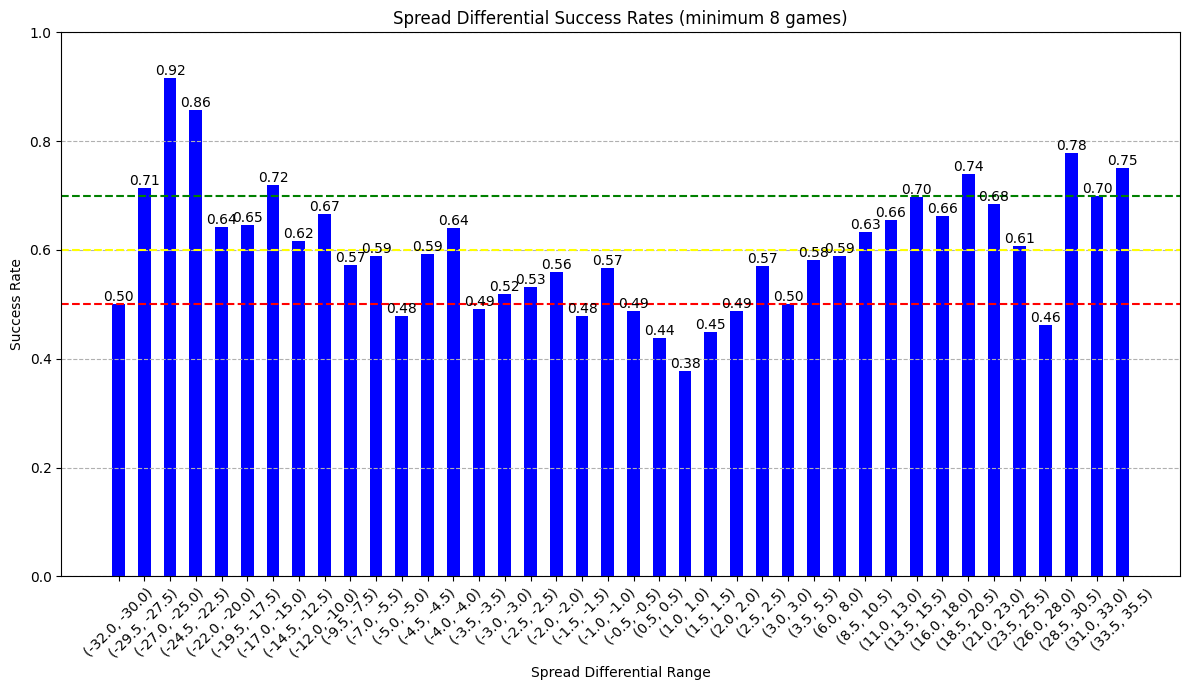

In [25]:
spreadDiffPlot(aggregateBins, 8)

This gives us a good visualization that we can use to see how well our model performs as it predicts further and further away from the Vegas spread.

Let's run the model from 2018-2023 multiple times so that we can get a larger amount of games to pull these bins from, therefore showing that it can have success in the long run over multiple uses. WARNING: This will take a very long time to run

In [26]:
aggregateData = [[],[],[]]

# running the model on all 5 years 5 times to get a large sample of games to pull from
for run in range(1, 11):

    # going through the last 5 years and seeing how the model performs on each of them
    for year in range(2018, 2024):
    
        if year == 2020:
            continue
    
        modelResults = modelPredictYear(year, features, None)

        aggregateData[0].extend(modelResults[0])
        aggregateData[1].extend(modelResults[1])
        aggregateData[2].extend(modelResults[2])
        
        print(f'{year} done')
        
    print(f'{run * 10}% done')

2018 done
2019 done
2021 done
2022 done
2023 done
10% done
2018 done
2019 done
2021 done
2022 done
2023 done
20% done
2018 done
2019 done
2021 done
2022 done
2023 done
30% done
2018 done
2019 done
2021 done
2022 done
2023 done
40% done
2018 done
2019 done
2021 done
2022 done
2023 done
50% done


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+00, tolerance: 8.773e-01
  model = cd_fast.enet_coordinate_descent(


2018 done
2019 done
2021 done
2022 done
2023 done
60% done
2018 done
2019 done
2021 done
2022 done
2023 done
70% done


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.091e+00, tolerance: 1.038e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.225e-01, tolerance: 7.474e-01
  model = cd_fast.enet_coordinate_descent(


2018 done
2019 done
2021 done
2022 done
2023 done
80% done
2018 done
2019 done
2021 done
2022 done
2023 done
90% done


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.241e-01, tolerance: 4.893e-01
  model = cd_fast.enet_coordinate_descent(


2018 done
2019 done
2021 done
2022 done
2023 done
100% done


Percent of all games our model was correct when predicting based on Vegas spreads: 57.02%
Percent of all games our model was wrong: 38.25%
Percent of all games our model pushed: 2.58%
Percent of all games that were tossups: 2.14%
Games: 41780
None
Won: 23825 
Lost: 15982 
Pushed: 1080 
Toss ups: 893 

Profit: $567709.09
None


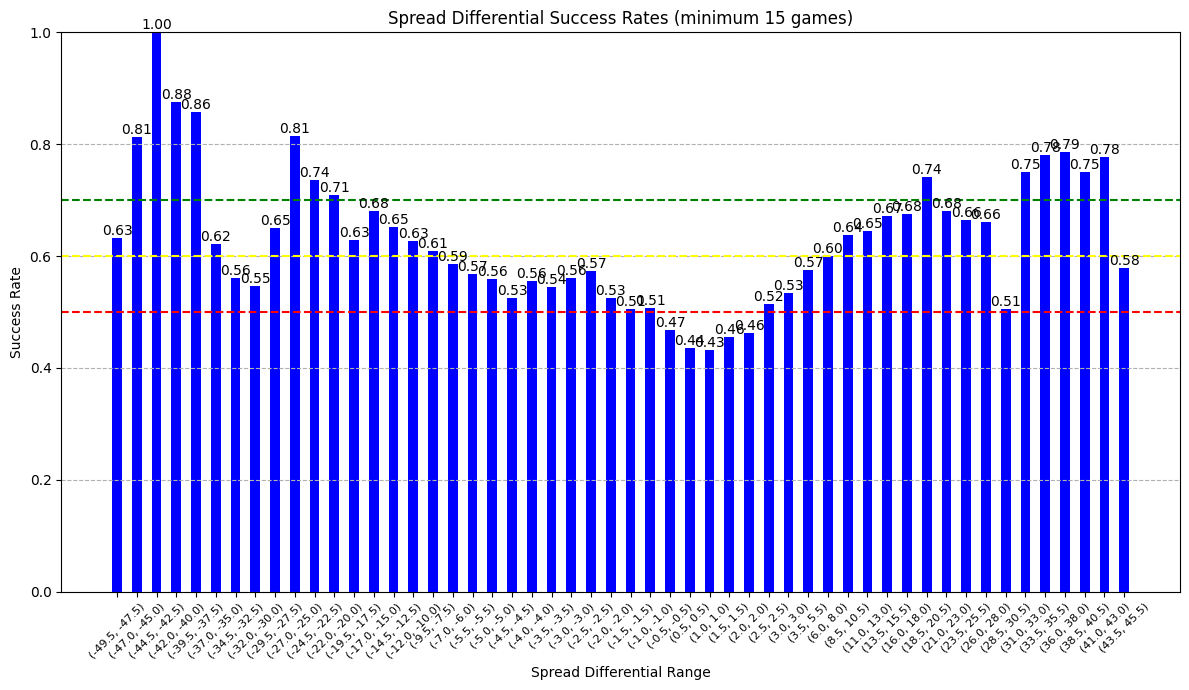

[[-49.5, -47.0, 0.631578947368421, 19], [-47.0, -44.5, 0.8125, 16], [-44.5, -42.0, 1.0, 21], [-42.0, -39.5, 0.875, 16], [-39.5, -37.0, 0.8571428571428571, 35], [-37.0, -34.5, 0.6216216216216216, 37], [-34.5, -32.0, 0.5616438356164384, 73], [-32.0, -29.5, 0.5463917525773195, 97], [-29.5, -27.0, 0.6507936507936508, 126], [-27.0, -24.5, 0.8148148148148148, 162], [-24.5, -22.0, 0.7368421052631579, 266], [-22.0, -19.5, 0.7097560975609756, 410], [-19.5, -17.0, 0.6295754026354319, 683], [-17.0, -14.5, 0.6813186813186813, 910], [-14.5, -12.0, 0.652542372881356, 1416], [-12.0, -9.5, 0.6265854895991883, 1971], [-9.5, -7.0, 0.6084484159220146, 2462], [-7.0, -5.5, 0.5865671641791045, 2010], [-5.5, -5.0, 0.5679487179487179, 780], [-5.0, -4.5, 0.559539052496799, 781], [-4.5, -4.0, 0.525030525030525, 819], [-4.0, -3.5, 0.5558060879368658, 887], [-3.5, -3.0, 0.5445205479452054, 876], [-3.0, -2.5, 0.5613636363636364, 880], [-2.5, -2.0, 0.5729047072330654, 871], [-2.0, -1.5, 0.5251716247139588, 874], [-

In [48]:
print(calculateModelResults(aggregateData[0]))
print(profitCalculator(100, aggregateData[0]))
aggregateBins = successByDeviation(aggregateData)
spreadDiffPlot(aggregateBins, 15)
print(aggregateBins)

Now we can see that over many runs of our model, it can consistenly perform at 57% and we now have a large dataset to pull from when looking at score differentials. Let's save these bins to a csv so we can easily refer back to them.

In [50]:
binData = pd.DataFrame(np.array(aggregateBins), columns = ['lowerBin', 'upperBin', 'successRate', 'gameCount'])

In [51]:
binData

,lowerBin,upperBin,successRate,gameCount
0,-49.5,-47.0,0.631579,19.0
1,-47.0,-44.5,0.812500,16.0
2,-44.5,-42.0,1.000000,21.0
3,-42.0,-39.5,0.875000,16.0
4,-39.5,-37.0,0.857143,35.0
5,-37.0,-34.5,0.621622,37.0
6,-34.5,-32.0,0.561644,73.0
7,-32.0,-29.5,0.546392,97.0
8,-29.5,-27.0,0.650794,126.0
9,-27.0,-24.5,0.814815,162.0


We can now use this data to see what percent of games historically our model has bet on with high success rates

In [66]:
# getting the % of 'good' bets, or bets that our model hits 60% of the time
sumGoodBet = sum(binData[binData['successRate'] >= 0.595]['gameCount'])
totalGames = sum(binData['gameCount'])
goodBetPercent = sumGoodBet / totalGames

# getting the % of 'great' bets, or bets that our model hits 65% of the time
sumGreatBet = sum(binData[binData['successRate'] >= 0.645]['gameCount'])
greatBetPercent = sumGreatBet / totalGames

# getting the % of 'best' bets, or bets that our model hits 70% of the time
sumBestBet = sum(binData[binData['successRate'] >= 0.695]['gameCount'])
bestBetPercent = sumBestBet / totalGames

print(f'Percent of bets we place that have had at least a 60% success rate {(goodBetPercent * 100):.2f}%')
print(f'Percent of bets we place that have had at least a 65% success rate {(greatBetPercent * 100):.2f}%')
print(f'Percent of bets we place that have had at least a 70% success rate {(bestBetPercent * 100):.2f}%')

Percent of bets we place that have had at least a 60% success rate 48.45%
Percent of bets we place that have had at least a 65% success rate 21.51%
Percent of bets we place that have had at least a 70% success rate 4.43%


Let's export this data to a csv, and in the next notebook we'll set up our 2024 model along with functions to easily update data mid season to make predictions.

In [70]:
path = os.path.join('/users/blaizelahman/Desktop/CFB Model', 'Bin_Data.csv')
binData.to_csv(path)